In [4]:
# libraries
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.model_selection import train_test_split # for train-test split
from sklearn.preprocessing import OneHotEncoder, StandardScaler # for categorical encoding
from sklearn.compose import ColumnTransformer # for combining transformations
from sklearn.pipeline import Pipeline # for creating a pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # for evaluation metrics
from sklearn.metrics import roc_auc_score, roc_curve # for ROC curve and AUC
import matplotlib.pyplot as plt # for plotting
from sklearn.model_selection import cross_val_predict # for cross-validation predictions
from sklearn.linear_model import LogisticRegressionCV # for cross-validated logistic regression
from sklearn.model_selection import StratifiedKFold # for stratified fold cross-validation
from sklearn.base import clone # for cloning models
from sklearn.model_selection import RepeatedStratifiedKFold # for repeated stratified fold cross-validation
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import joblib








In [ ]:
# Load data
master_df = pd.read_csv('C:\\Users\\Hassan\\Documents\\Projects\\baard\\baard_master_sheet.csv')


# make variable had_fall if total_number_falls > 0
master_df['had_fall'] = (master_df['total_number_falls'] > 0).astype(int)

# add new varaible BMI_extremer, where 1 = bmi > 40 or < 20, binary variables
master_df['BMI_extreme'] = ((master_df['bmi'] > 40) | (master_df['bmi'] < 20)).astype(int)

 
ON_both = master_df[master_df['medication_group'].isin(["ARIPIPRAZOLE", "BUPROPION"])]

ON_arp = master_df[master_df['medication_group'] == "ARIPIPRAZOLE"]

ON_bup = master_df[master_df['medication_group'] == "BUPROPION"]


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def compute_sasp_index(df):
    # biomarker columns in master_sheet
    biomarker_cols = [
        'IL-6', 'gp130', 'IL-8/CXCL8', 'uPAR', 'MIF',
        'CCL2/JE/MCP-1', 'Osteoprotegerin/TNFRSF11B', 'IL-1 beta/IL-1F2',
        'CCL20/MIP-3 alpha', 'CCL3/MIP-1 alpha', 'CCL4/MIP-1 beta',
        'CCL13/MCP-4', 'GM-CSF', 'ICAM-1/CD54', 'TNF RII/TNFRSF1B',
        'TNF RI/TNFRSF1A', 'PIGF', 'CXCL1/GRO alpha/KC/CINC-1',
        'IGFBP-2', 'TIMP-1', 'IGFBP-6', 'Angiogenin'
    ]

    # weights from Breno
    weights = [
        0.282894877,  # IL-6
        0.123199448,  # gp130
        0.308384372,  # IL-8
        0.204622649,  # uPAR
        0.058976240,  # MIF
        0.291745272,  # CCL2
        0.221205524,  # Osteoprotegerin
        0.255700198,  # IL-1b
        0.208287277,  # CCL20
        0.193388148,  # CCL3
        0.289456430,  # CCL4
        0.289657031,  # CCL13
        0.088343487,  # GM-CSF
        0.122586493,  # ICAM1
        0.248676185,  # TNFR2
        0.286050168,  # TNFR1
        0.030422109,  # PLGF
        0.189362370,  # CXCL1
        0.052284421,  # IGFBP-2
        0.124990789,  # TIMP-1
        0.236375717,  # IGFBP-6
        0.197317664   # Angiogenin
    ]

    # fail safe check 
    if len(biomarker_cols) != len(weights):
        raise ValueError("Number of biomarkers and weights must match.") 

    # subset dataframe so we use only biomarker columns for z-scoring
    biomarker_df = df[biomarker_cols].copy()

    # z-score the biomarkers
    scaler = StandardScaler()
    biomarker_z = pd.DataFrame(
        scaler.fit_transform(biomarker_df),
        columns=biomarker_cols,
        index=df.index
    )

    # use dots to do weighted sum and create new column SASP_index
    df['SASP_index'] = biomarker_z.dot(weights)

    return df

def compute_sasp_index_sqrt(df):
    # biomarker columns in master_sheet
    biomarker_cols = [
        'IL-6_sqrt', 'gp130_sqrt', 'IL-8/CXCL8_sqrt', 'uPAR_sqrt', 'MIF_sqrt',
        'CCL2/JE/MCP-1_sqrt', 'Osteoprotegerin/TNFRSF11B_sqrt', 'IL-1 beta/IL-1F2_sqrt',
        'CCL20/MIP-3 alpha_sqrt', 'CCL3/MIP-1 alpha_sqrt', 'CCL4/MIP-1 beta_sqrt',
        'CCL13/MCP-4_sqrt', 'GM-CSF_sqrt', 'ICAM-1/CD54_sqrt', 'TNF RII/TNFRSF1B_sqrt',
        'TNF RI/TNFRSF1A_sqrt', 'PIGF_sqrt', 'CXCL1/GRO alpha/KC/CINC-1_sqrt',
        'IGFBP-2_sqrt', 'TIMP-1_sqrt', 'IGFBP-6_sqrt', 'Angiogenin_sqrt']

    # weights from Breno
    weights = [
        0.282894877,  # IL-6
        0.123199448,  # gp130
        0.308384372,  # IL-8
        0.204622649,  # uPAR
        0.058976240,  # MIF
        0.291745272,  # CCL2
        0.221205524,  # Osteoprotegerin
        0.255700198,  # IL-1b
        0.208287277,  # CCL20
        0.193388148,  # CCL3
        0.289456430,  # CCL4
        0.289657031,  # CCL13
        0.088343487,  # GM-CSF
        0.122586493,  # ICAM1
        0.248676185,  # TNFR2
        0.286050168,  # TNFR1
        0.030422109,  # PLGF
        0.189362370,  # CXCL1
        0.052284421,  # IGFBP-2
        0.124990789,  # TIMP-1
        0.236375717,  # IGFBP-6
        0.197317664   # Angiogenin
    ]

    # fail safe check 
    if len(biomarker_cols) != len(weights):
        raise ValueError("Number of biomarkers and weights must match.") 

    # subset dataframe so we use only biomarker columns for z-scoring
    biomarker_df = df[biomarker_cols].copy()

    # z-score the biomarkers
    scaler = StandardScaler()
    biomarker_z = pd.DataFrame(
        scaler.fit_transform(biomarker_df),
        columns=biomarker_cols,
        index=df.index
    )

    # use dots to do weighted sum and create new column SASP_index
    df['SASP_index_sqrt'] = biomarker_z.dot(weights)

    return df


In [7]:
master_df = compute_sasp_index(master_df)

In [ ]:


###### prepare the data for modeling #########


## new clin demo variables = age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme',
                ## add to models and see difference

ON_bup_cog = ON_bup.dropna(subset=['MTOTALIS_01'])
ON_bup_cog = ON_bup_cog[~ON_bup_cog['record_id'].str.startswith('CU')]
#select the demographic columns and cog columns
ON_bup_cog = ON_bup_cog[['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme', 'AIS_01',	'MDMIS_01',	'LIS_01',	'MVCIS_01',	'IMIS_01',	'MTOTALIS_01','CWI3CSSFinal_01','DERRSS4_01','CWI4CSSFinal_01','DTMT4ER_01','DTMT4CO_01','DTMT4_01','DTMTS4_01','RCS_Z_01',	'RDS_Z_01',	'RFC_Z_01',	'RFR_Z_01',	'RLO_Z_01',	'RLL_Z_01',	'RREC_Z_01'	,'PICTURE_Z_01',	'RSR_Z_01',	'RSF_Z_01'	,'RSM_Z_01']].dropna()
ON_arp_cog = ON_arp.dropna(subset=['MTOTALIS_01'])
ON_arp_cog = ON_arp_cog[['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme', 'AIS_01',	'MDMIS_01',	'LIS_01',	'MVCIS_01',	'IMIS_01',	'MTOTALIS_01','CWI3CSSFinal_01','DERRSS4_01','CWI4CSSFinal_01','DTMT4ER_01','DTMT4CO_01','DTMT4_01','DTMTS4_01','RCS_Z_01',	'RDS_Z_01',	'RFC_Z_01',	'RFR_Z_01',	'RLO_Z_01',	'RLL_Z_01',	'RREC_Z_01'	,'PICTURE_Z_01',	'RSR_Z_01',	'RSF_Z_01'	,'RSM_Z_01']].dropna()

ON_arp_cog = ON_arp_cog[~ON_arp_cog['record_id'].str.startswith('CU')]

## prepare the data for modeling -- demographic variables + clin + nih cog

ON_bup_nih =ON_bup.dropna(subset=['fcc_baseline'])
ON_bup_nih = ON_bup_nih[~ON_bup_nih['record_id'].str.startswith('CU')]
ON_bup_nih = ON_bup_nih[['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme', 'fcc_baseline',	'dccs_baseline',	'flanker_baseline',	'listSort_baseline',	'pattComp_baseline'	,'psm_baseline']].dropna()



ON_arp_nih =ON_arp.dropna(subset=['fcc_baseline'])
ON_arp_nih = ON_arp_nih[~ON_arp_nih['record_id'].str.startswith('CU')]
ON_arp_nih = ON_arp_nih[['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme', 'fcc_baseline',	'dccs_baseline',	'flanker_baseline',	'listSort_baseline',	'pattComp_baseline'	,'psm_baseline']]

#select the demographic columns and cog columns
ON_arp_cog = ON_arp_cog[['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme', 'AIS_01',	'MDMIS_01',	'LIS_01',	'MVCIS_01',	'IMIS_01',	'MTOTALIS_01','CWI3CSSFinal_01','DERRSS4_01','CWI4CSSFinal_01','DTMT4ER_01','DTMT4CO_01','DTMT4_01','DTMTS4_01','RCS_Z_01',	'RDS_Z_01',	'RFC_Z_01',	'RFR_Z_01',	'RLO_Z_01',	'RLL_Z_01',	'RREC_Z_01'	,'PICTURE_Z_01',	'RSR_Z_01',	'RSF_Z_01'	,'RSM_Z_01']]

## prepare the data for modeling -- demographis + clin + blood 
ON_bup_blood = ON_bup[['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme','IL-6_sqrt', 'gp130_sqrt', 'IL-8/CXCL8_sqrt', 'uPAR_sqrt', 'MIF_sqrt',
        'CCL2/JE/MCP-1_sqrt', 'Osteoprotegerin/TNFRSF11B_sqrt', 'IL-1 beta/IL-1F2_sqrt',
        'CCL20/MIP-3 alpha_sqrt', 'CCL3/MIP-1 alpha_sqrt', 'CCL4/MIP-1 beta_sqrt',
        'CCL13/MCP-4_sqrt', 'GM-CSF_sqrt', 'ICAM-1/CD54_sqrt', 'TNF RII/TNFRSF1B_sqrt',
        'TNF RI/TNFRSF1A_sqrt', 'PIGF_sqrt', 'CXCL1/GRO alpha/KC/CINC-1_sqrt',
        'IGFBP-2_sqrt', 'TIMP-1_sqrt', 'IGFBP-6_sqrt', 'Angiogenin_sqrt']].dropna()
ON_bup_blood = ON_bup_blood[~ON_bup_blood['record_id'].str.startswith('CU')]
ON_arp_blood = ON_arp[['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status','IL-6_sqrt', 'gp130_sqrt', 'IL-8/CXCL8_sqrt', 'uPAR_sqrt', 'MIF_sqrt',
        'CCL2/JE/MCP-1_sqrt', 'Osteoprotegerin/TNFRSF11B_sqrt', 'IL-1 beta/IL-1F2_sqrt',
        'CCL20/MIP-3 alpha_sqrt', 'CCL3/MIP-1 alpha_sqrt', 'CCL4/MIP-1 beta_sqrt',
        'CCL13/MCP-4_sqrt', 'GM-CSF_sqrt', 'ICAM-1/CD54_sqrt', 'TNF RII/TNFRSF1B_sqrt',
        'TNF RI/TNFRSF1A_sqrt', 'PIGF_sqrt', 'CXCL1/GRO alpha/KC/CINC-1_sqrt',
        'IGFBP-2_sqrt', 'TIMP-1_sqrt', 'IGFBP-6_sqrt', 'Angiogenin_sqrt']].dropna()
ON_arp_blood = ON_arp_blood[~ON_arp_blood['record_id'].str.startswith('CU')]

## prepare the data for modeling -- demographic variables + smri
ON_bup_smri = ON_bup.dropna(subset=['Right.Amygdala_etiv'])
# select the demographics and smri columns
ON_bup_smri = ON_bup_smri[['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme'

] + list(ON_bup_smri.loc[:, 'WM.hypointensities_log':'Default_to_DorsAttn'].columns)] # change Right.Amygdala_etiv to DorsAttn, to get smri in addition to basic within network connectivity or Default_to_DorsAttn to get within network and network by network

ON_arp_smri = ON_arp.dropna(subset=['Right.Amygdala_etiv'])
# select the demographics and smri columns
ON_arp_smri = ON_arp_smri[['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme'] + list(ON_arp_smri.loc[:, 'WM.hypointensities_log':'Default_to_DorsAttn'].columns)] # change Right.Amygdala_etiv to DorsAttn, to get smri in addition to basic within network connectivity or Default_to_DorsAttn to get within network and network by network


ON_arp_genetics = ON_arp.dropna(subset=['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme','rs1801131_T','rs1801133_G','rs1045642_G','rs12248560_C','rs4244285_G','rs1799853_C','rs1057910_A','rs4149056_T','rs116855232_C','rs9923231_C','rs2108622_C'
])


ON_bup_genetics = ON_bup.dropna(subset=['record_id','age', 'gender', 'edu_lvl', 'baseline_madrs', 'remission_status',  'mini_6', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme','rs1801131_T','rs1801133_G','rs1045642_G','rs12248560_C','rs4244285_G','rs1799853_C','rs1057910_A','rs4149056_T','rs116855232_C','rs9923231_C','rs2108622_C'
])

ON_bup_cog_smri = ON_bup.dropna(subset=['MTOTALIS_01', 'Right.Amygdala_etiv'])

In [ ]:
# run correlations between variables just in case
print("Correlation between :", df['mini_6'].corr(df['years_with_depression']))

Iteration 1/50 — Train size: 85, Test size: 22
Iteration 2/50 — Train size: 85, Test size: 22
Iteration 3/50 — Train size: 85, Test size: 22
Iteration 4/50 — Train size: 85, Test size: 22
Iteration 5/50 — Train size: 85, Test size: 22
Iteration 6/50 — Train size: 85, Test size: 22
Iteration 7/50 — Train size: 85, Test size: 22
Iteration 8/50 — Train size: 85, Test size: 22
Iteration 9/50 — Train size: 85, Test size: 22
Iteration 10/50 — Train size: 85, Test size: 22
Iteration 11/50 — Train size: 85, Test size: 22
Iteration 12/50 — Train size: 85, Test size: 22
Iteration 13/50 — Train size: 85, Test size: 22
Iteration 14/50 — Train size: 85, Test size: 22
Iteration 15/50 — Train size: 85, Test size: 22
Iteration 16/50 — Train size: 85, Test size: 22
Iteration 17/50 — Train size: 85, Test size: 22
Iteration 18/50 — Train size: 85, Test size: 22
Iteration 19/50 — Train size: 85, Test size: 22
Iteration 20/50 — Train size: 85, Test size: 22
Iteration 21/50 — Train size: 85, Test size: 22
I

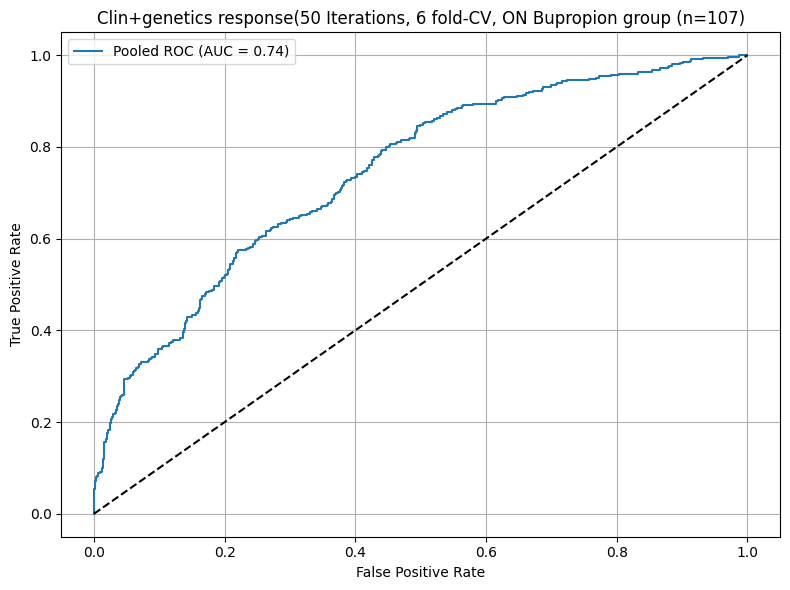

In [27]:

# Logistic Regression with Elastic Net Regularization (mri + clin)

    # change l1 ratio, higher is ridge - so less 0s. change C to 50 -- 100, split just ct and then volumes or both -- see what performs better
    ## np.arange(5.0, 15.5, 0.5).tolist() do this to grid search over C




df = ON_arp_genetics.copy()
df['sex'] = (df['gender'] == 'Male').astype(int)
df['mini_addtl_q1'] = pd.to_numeric(df['mini_addtl_q1'], errors='coerce')
# in mini 6 remove non numerical values
#df['mini_6'] = pd.to_numeric(df['mini_6'], errors='coerce')
# drop na values
df = df.dropna(subset=['mini_addtl_q1', ])
df = df[['record_id','age', 'sex', 'edu_lvl', 'baseline_madrs', 'remission_status',   'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme','rs1801131_T','rs1801133_G','rs1045642_G','rs12248560_C','rs4244285_G','rs1799853_C','rs1057910_A','rs4149056_T','rs116855232_C','rs9923231_C','rs2108622_C'
]].dropna()

X = df[[ 'age', 'sex', 'edu_lvl', 'baseline_madrs', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme','rs1801133_G','rs1045642_G','rs12248560_C','rs4244285_G','rs1799853_C','rs1057910_A','rs4149056_T','rs116855232_C','rs9923231_C']].values
y = df['remission_status'].astype(int).values
feature_names = [ 'age', 'sex', 'edu_lvl', 'baseline_madrs',  'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme','rs1801133_G','rs1045642_G','rs12248560_C','rs4244285_G','rs1799853_C','rs1057910_A','rs4149056_T','rs116855232_C','rs9923231_C'  ]


#  config for the model
test_ratio = 0.20
n_splits = 50 # number of repeated random splits
threshold = 0.27 # threshold for classification, 0.27 is the threshold where sensitivity and specificity are balanced
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_ratio, random_state=42)

# Storage
all_y_true = []
all_y_scores = []
all_y_pred = []
coef_list = []
fold_metrics = []
per_fold_preds = []

# loop over outter folds
for fold_num, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"Iteration {fold_num+1}/{n_splits} — Train size: {len(train_idx)}, Test size: {len(test_idx)}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_ids = df.iloc[test_idx]['record_id'].values

    clf = LogisticRegressionCV(
        penalty='elasticnet',
        solver='saga',
        Cs=[10],
        cv=4,
        l1_ratios=[0.1], 
        scoring='neg_log_loss',
        max_iter=1000000)
    clf.fit(X_train, y_train)

    y_score = clf.predict_proba(X_test)[:, 1]
    y_pred = (y_score >= threshold).astype(int)

    # Store true/pred/scores
    all_y_true.extend(y_test)
    all_y_scores.extend(y_score)
    all_y_pred.extend(y_pred)
    coef_list.append(clf.coef_.flatten())

    # Confusion matrix per fold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) else 0
    specificity = tn / (tn + fp) if (tn + fp) else 0
    fold_auc = roc_auc_score(y_test, y_score)
    # find balanced accuracy
    balanced_accuracy = (sensitivity + specificity) / 2



    fold_metrics.append({
        'iteration': fold_num + 1,
        'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': fold_auc,
        'Balanced Accuracy': balanced_accuracy,
        "best C": clf.C_[0],
        "best l1_ratio": clf.l1_ratio_[0]
    })
    # NEW: save per-fold predictions with record_id
    per_fold_preds.append(pd.DataFrame({
        'iteration': fold_num + 1,
        'record_id': test_ids,
        'y_true': y_test,
        'y_score': y_score,       # probability of remission
        'y_pred': y_pred
    }))

# Compute ROC curve on pooled predictions
fpr, tpr, thresholds = roc_curve(all_y_true, all_y_scores)

# Find threshold where sensitivity ≈ specificity
specificity = 1 - fpr
diff = np.abs(tpr - specificity)
best_idx = np.argmin(diff)
balanced_threshold = thresholds[best_idx]

print(f"\nBalanced Sensitivity/Specificity threshold: {balanced_threshold:.3f}")

print(f"Sensitivity: {tpr[best_idx]:.3f}, Specificity: {specificity[best_idx]:.3f}")


print(f'Balanced Accuracy: {balanced_accuracy:.3f}')


#  metrics
df_metrics = pd.DataFrame(fold_metrics)
df_coefs = pd.DataFrame(coef_list, columns=feature_names)

# average balanced accuracy
average_balanced_accuracy = df_metrics['Balanced Accuracy'].mean()
print(f"Average Balanced Accuracy: {average_balanced_accuracy:.3f}")
# average coefficients
average_coefs = df_coefs.mean()
print("\nAverage Coefficients:")

for feature, coef in average_coefs.items():
    print(f"{feature}: {coef:.3f}")

#  pooled results
pooled_auc = roc_auc_score(all_y_true, all_y_scores)
fpr, tpr, _ = roc_curve(all_y_true, all_y_scores)

print(f"\nPooled AUC: {pooled_auc:.3f}")
print("\nAverage per-fold metrics:")
print(df_metrics[['Accuracy', 'Sensitivity', 'Specificity', 'AUC', 'best C', 'best l1_ratio']].mean())

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Pooled ROC (AUC = {pooled_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Clin+genetics response({n_splits} Iterations, 6 fold-CV, ON Bupropion group (n={len(df)})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


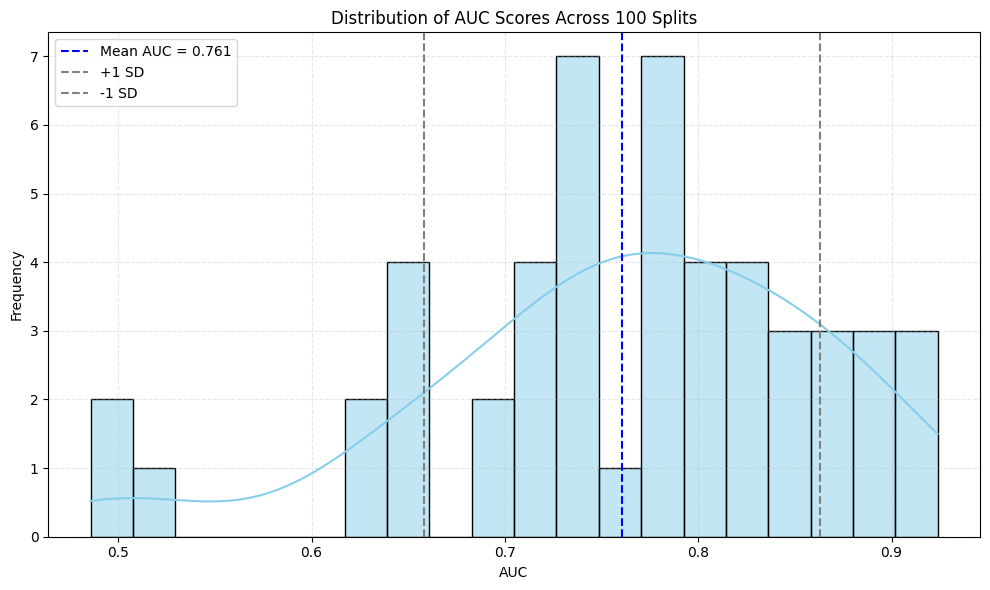

In [28]:
## plot distribution of AUC scores across folds with mean and ±1 SD lines

plt.figure(figsize=(10, 6))
sns.histplot(df_metrics['AUC'], kde=True, bins=20, color='skyblue')

# Mean and ±1 SD lines
mean_auc = df_metrics['AUC'].mean()
std_auc = df_metrics['AUC'].std()

plt.axvline(mean_auc, color='blue', linestyle='--', label=f"Mean AUC = {mean_auc:.3f}")
plt.axvline(mean_auc + std_auc, color='gray', linestyle='--', label='+1 SD')
plt.axvline(mean_auc - std_auc, color='gray', linestyle='--', label='-1 SD')

plt.title("Distribution of AUC Scores Across 100 Splits")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
## output results -- coefs, metrics, preds, model

df_coefs.to_csv("ON_arp_nih_coefs.csv", index=False)

# make fold metrics a DataFrame
df_metrics = pd.DataFrame(fold_metrics)

df_metrics.to_csv('bup_clin_per_fold_metrics.csv', index=False)

df_preds = pd.concat(per_fold_preds, ignore_index=True)

oof_by_id = (df_preds.groupby('record_id', as_index=False)
             .agg(mean_prob=('y_score','mean'),
                  std_prob=('y_score','std'),
                  times_tested=('y_score','size'),
                  y_true=('y_true','first'))
             .sort_values('mean_prob', ascending=False))
# oof_by_id has exactly one row per record_id with their OOS probability


# save results
oof_by_id.to_csv('ON_bup_cog_predictions.csv', index=False)



# save the model
joblib.dump(clf, 'BAARD_bup_clin_model.joblib')





### All in one plot

In [30]:


df = ON_arp_genetics.copy() 
df['sex'] = (df['gender'] == 'Male').astype(int)
df['mini_addtl_q1'] = pd.to_numeric(df['mini_addtl_q1'], errors='coerce')
# in mini 6 remove non numerical values
df['mini_6'] = pd.to_numeric(df['mini_6'], errors='coerce')
# drop na values
df = df.dropna(subset=['mini_addtl_q1', ])
df = df[['age', 'sex', 'edu_lvl', 'baseline_madrs', 'remission_status', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme','rs1801131_T','rs1801133_G','rs1045642_G','rs12248560_C','rs4244285_G','rs1799853_C','rs1057910_A','rs4149056_T','rs116855232_C','rs9923231_C','rs2108622_C']].dropna()

# Configuration
test_ratio = 0.20
n_splits = 10
threshold = 0.35
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_ratio, random_state=42)
feature_set_names = [ 'rs1801131_T','rs1801133_G','rs1045642_G','rs12248560_C','rs4244285_G','rs1799853_C','rs1057910_A','rs4149056_T','rs116855232_C','rs9923231_C','rs2108622_C']

# Storage for ROC curves
roc_results = {}

for feature_name in feature_set_names:
    print(f"\n=== Running model using feature: {feature_name} ===")
    
    X = df[['age', 'sex', 'edu_lvl', 'baseline_madrs',    feature_name]].values
    y = df['remission_status'].astype(int).values
    feature_names = ['age', 'sex', 'edu_lvl', 'baseline_madrs',   feature_name]

    all_y_true = []
    all_y_scores = []

    for fold_num, (train_idx, test_idx) in enumerate(sss.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = LogisticRegressionCV(
            penalty='elasticnet',
            solver='saga',
            Cs=10,
            cv=4,
            l1_ratios=[0.1],
            scoring='neg_log_loss',
            max_iter=1000000,
            refit=True
        )
        clf.fit(X_train, y_train)

        y_score = clf.predict_proba(X_test)[:, 1]
        all_y_true.extend(y_test)
        all_y_scores.extend(y_score)

    pooled_auc = roc_auc_score(all_y_true, all_y_scores)
    fpr, tpr, _ = roc_curve(all_y_true, all_y_scores)

    roc_results[feature_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': pooled_auc
    }

# === BASELINE MODEL: Demographics + baseline MADRS only ===
print("\n=== Running baseline model: age + sex + edu_lvl + baseline_madrs ===")

X_base = df[['age', 'sex', 'edu_lvl', 'baseline_madrs', 'mini_addtl_q1','athf_f1_total_trials_v2','years_with_depression','BMI_extreme']].values
y_base = df['remission_status'].astype(int).values

all_y_true_base = []
all_y_scores_base = []

for fold_num, (train_idx, test_idx) in enumerate(sss.split(X_base, y_base)):
    X_train_base, X_test_base = X_base[train_idx], X_base[test_idx]
    y_train_base, y_test_base = y_base[train_idx], y_base[test_idx]

    clf_base = LogisticRegressionCV(
        penalty='elasticnet',
        solver='saga',
        Cs=10,
        cv=4,
        l1_ratios=[0.1],
        scoring='neg_log_loss',
        max_iter=1000000,
        refit=True
    )
    clf_base.fit(X_train_base, y_train_base)

 

    y_score_base = clf_base.predict_proba(X_test_base)[:, 1]
    all_y_true_base.extend(y_test_base)
    all_y_scores_base.extend(y_score_base)

# Compute ROC and AUC for baseline model
pooled_auc_base = roc_auc_score(all_y_true_base, all_y_scores_base)
fpr_base, tpr_base, _ = roc_curve(all_y_true_base, all_y_scores_base)

roc_results['Clinical only'] = {
    'fpr': fpr_base,
    'tpr': tpr_base,
    'auc': pooled_auc_base
}



=== Running model using feature: rs1801131_T ===

=== Running model using feature: rs1801133_G ===

=== Running model using feature: rs1045642_G ===

=== Running model using feature: rs12248560_C ===

=== Running model using feature: rs4244285_G ===

=== Running model using feature: rs1799853_C ===

=== Running model using feature: rs1057910_A ===

=== Running model using feature: rs4149056_T ===

=== Running model using feature: rs116855232_C ===

=== Running model using feature: rs9923231_C ===

=== Running model using feature: rs2108622_C ===

=== Running baseline model: age + sex + edu_lvl + baseline_madrs ===


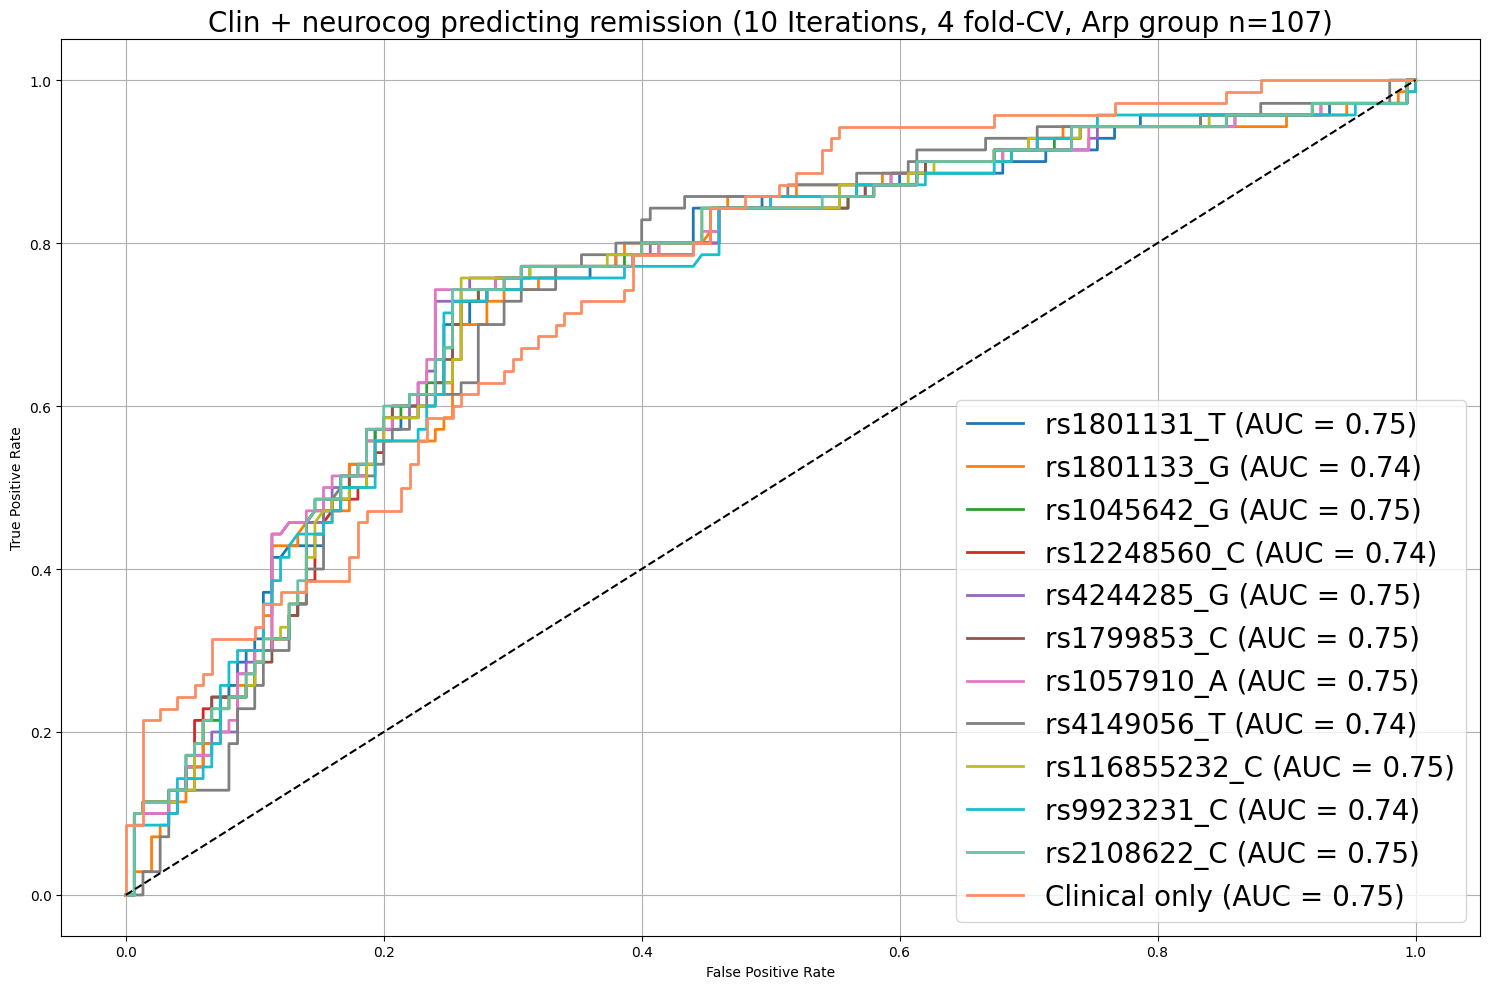

In [32]:


# plot all ROC curves together
plt.figure(figsize=(15, 10))


from itertools import cycle
colors = cycle(plt.cm.tab10.colors + plt.cm.Set2.colors + plt.cm.Dark2.colors)

for feature_name, result in roc_results.items():
    plt.plot(result['fpr'], result['tpr'],
             label=f'{feature_name} (AUC = {result["auc"]:.2f})',
             linewidth=2,
             color=next(colors))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Clin + neurocog predicting remission ({n_splits} Iterations, 4 fold-CV, Arp group n={len(df)})', fontsize=20)

plt.legend(fontsize =20)
plt.grid(True)
plt.tight_layout()
plt.show()